# Projekt 02: Redukcja wymiarowości
Filip Misiak

Zestaw danych: Spambase (UCI Machine Learning Repository)

Import bibliotek

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [168]:
!pip install ucimlrepo

Ustawienia wizualizacji

In [169]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# CZĘŚĆ 1: PRZYGOTOWANIE DANYCH

# 1.1. Wczytanie danych

In [170]:
from ucimlrepo import fetch_ucirepo
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.values.ravel()

# 1.2. Eksploracyjna Analiza Danych (EDA)

In [171]:
print(f"\nRozmiar zbioru danych: {X.shape[0]} obserwacji, {X.shape[1]} cech")
print(f"Rozkład klas: {np.bincount(y)}")
print(f"Proporcje klas: Nie-spam: {(y==0).sum()/len(y)*100:.1f}%, Spam: {(y==1).sum()/len(y)*100:.1f}%")

# Podstawowe statystyki
print("\nPodstawowe statystyki zbioru danych:")
print(X.describe())


Rozmiar zbioru danych: 4601 obserwacji, 57 cech
Rozkład klas: [2788 1813]
Proporcje klas: Nie-spam: 60.6%, Spam: 39.4%

Podstawowe statystyki zbioru danych:
       word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4601.000000        4601.000000    4601.000000   4601.000000   
mean         0.104553           0.213015       0.280656      0.065425   
std          0.305358           1.290575       0.504143      1.395151   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.420000      0.000000   
max          4.540000          14.280000       5.100000     42.810000   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4601.000000     4601.000000       4601.000000         4601.000000   
mean        0.312223        

In [172]:
# Sprawdzenie wartości brakujących
missing_values = X.isnull().sum().sum()
print(f"\nLiczba wartości brakujących: {missing_values}")
# if missing_values > 0:
#     print("Wartości brakujące według kolumn:")
#     print(X.isnull().sum()[X.isnull().sum() > 0])
#     # Uzupełnienie wartości brakujących medianą
#     X = X.fillna(X.median())
#     print("Wartości brakujące uzupełnione medianą")
# else:
print("Brak wartości brakujących w zbiorze danych")


Liczba wartości brakujących: 0
Brak wartości brakujących w zbiorze danych


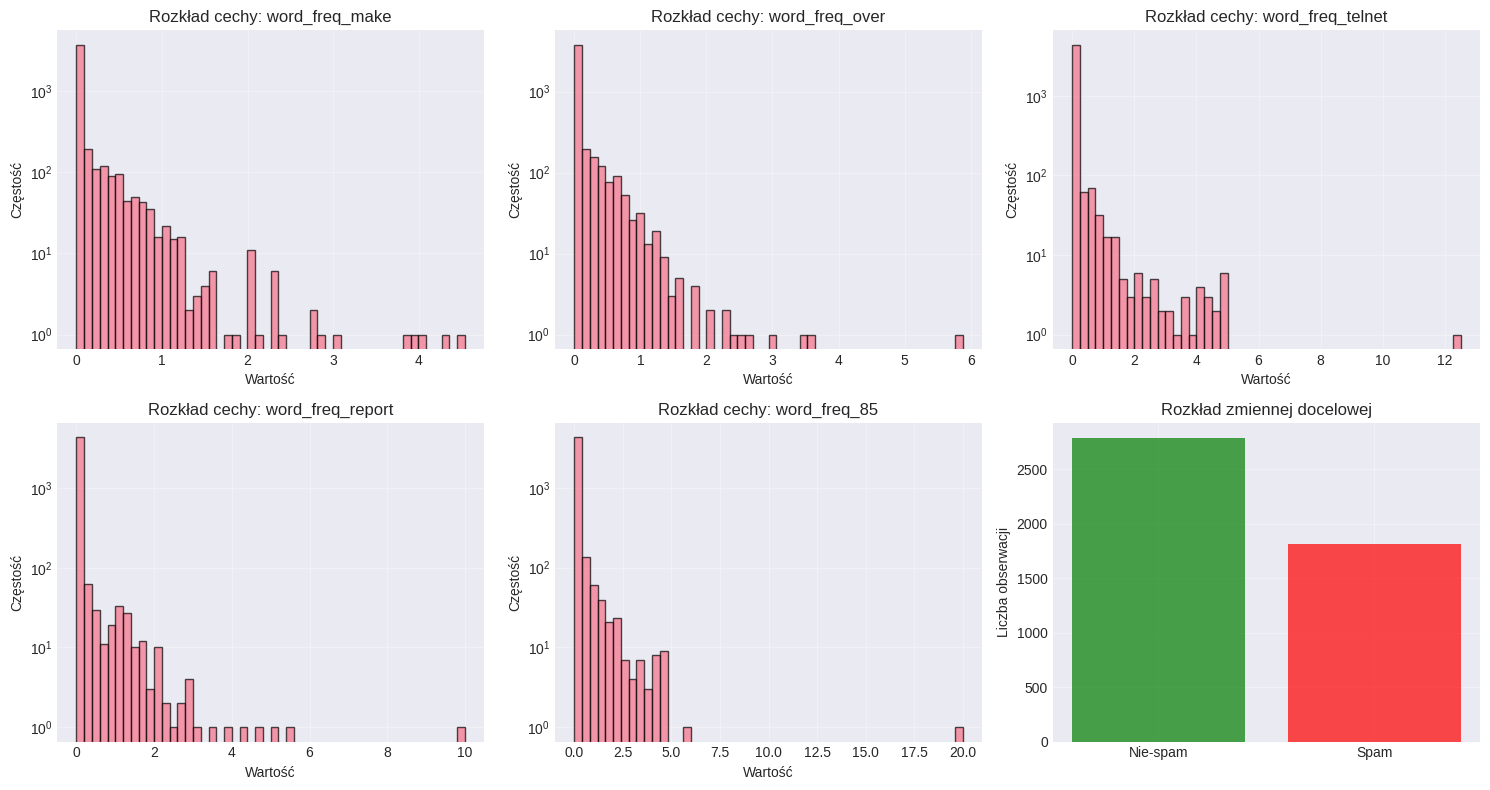

In [210]:
# Rozkłady cech - histogramy dla 5 losowych cech
np.random.seed(42)
random_features = np.random.choice(X.columns, size=5, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, feature in enumerate(random_features):
    axes[idx].hist(X[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Rozkład cechy: {feature}')
    axes[idx].set_xlabel('Wartość')
    axes[idx].set_ylabel('Częstość')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yscale("log")

# Rozkład zmiennej docelowej
axes[5].bar(['Nie-spam', 'Spam'], np.bincount(y), color=['green', 'red'], alpha=0.7)
axes[5].set_title('Rozkład zmiennej docelowej')
axes[5].set_ylabel('Liczba obserwacji')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

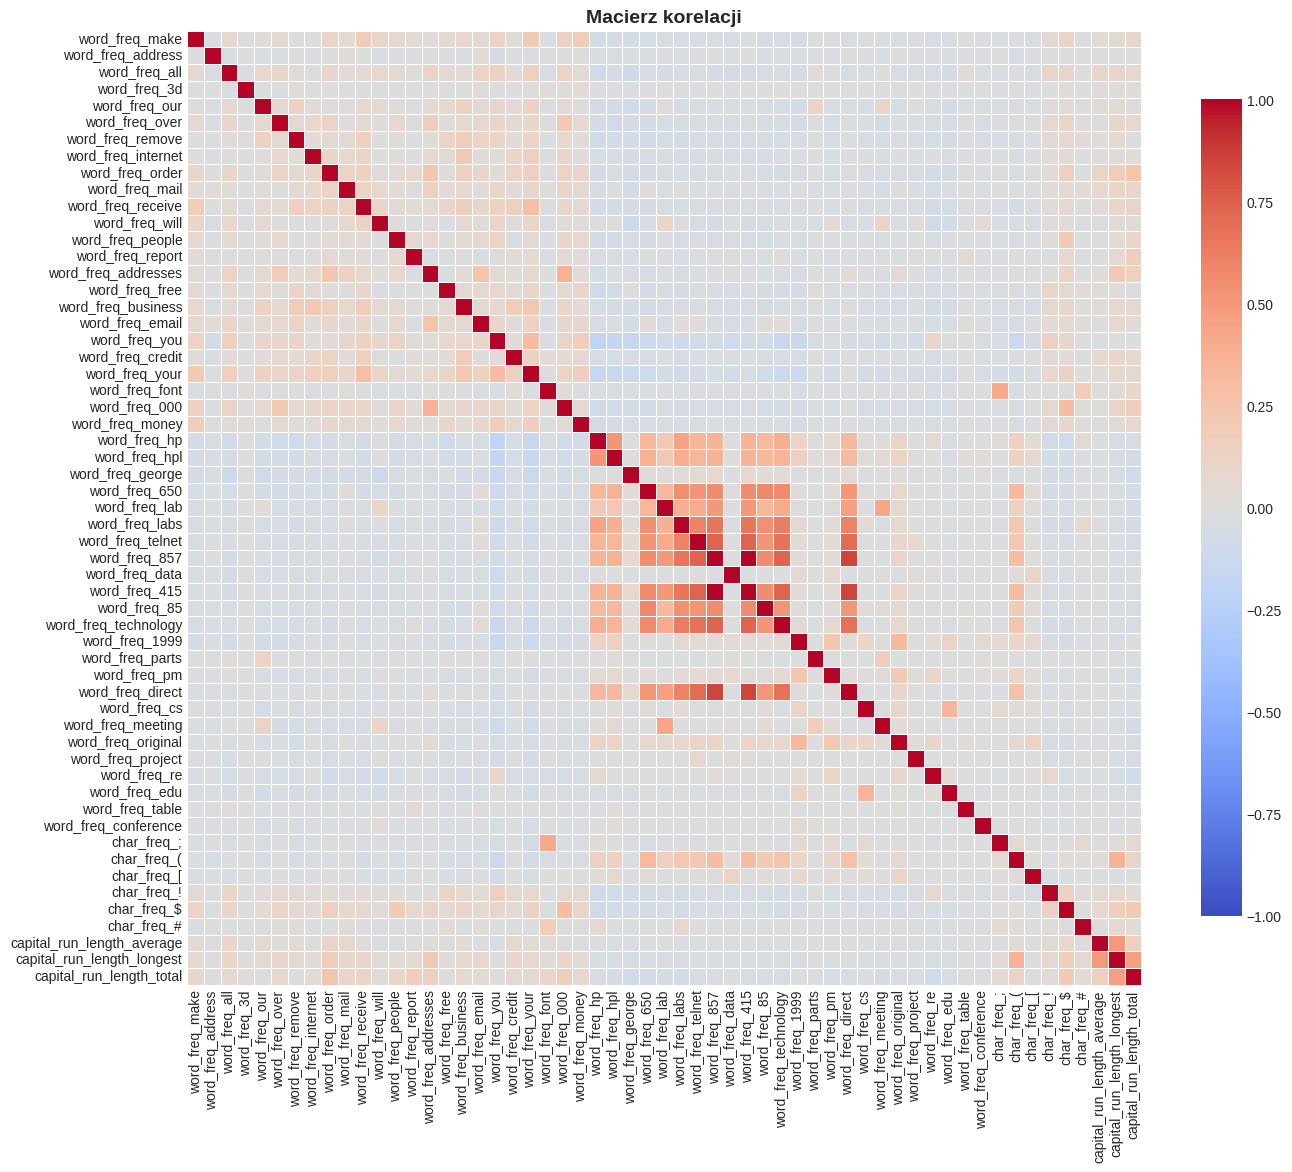

In [174]:
# Macierz korelacji
correlation_matrix = X.iloc[:, :].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Macierz korelacji', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [175]:
# Analiza najsilniejszych korelacji
corr_with_target = pd.DataFrame(X.columns, columns=['Feature'])
# Tworzymy tymczasowy DataFrame z cechami i targetem
temp_df = X.copy()
temp_df['target'] = y
corr_values = temp_df.corr()['target'].drop('target').abs().sort_values(ascending=False)
print("\nTop 10 cech najsilniej skorelowanych z target:")
print(corr_values.head(10))


Top 10 cech najsilniej skorelowanych z target:
word_freq_your              0.383234
word_freq_000               0.334787
word_freq_remove            0.332117
char_freq_$                 0.323629
word_freq_you               0.273651
word_freq_free              0.263215
word_freq_business          0.263204
word_freq_hp                0.256723
capital_run_length_total    0.249164
word_freq_our               0.241920
Name: target, dtype: float64


# Charakterystyka zbioru danych
Zbiór danych Spambase zawiera 4601 obserwacji opisanych przez 57 cech numerycznych.
Cechy reprezentują częstotliwości występowania określonych słów i znaków w emailach,
oraz statystyki dotyczące użycia wielkich liter. Zadaniem jest klasyfikacja binarna:
rozróżnienie spamu od prawdziwych wiadomości. Klasy są względnie zbilansowane
60.6%, Spam: 39.4%, co ułatwia trenowanie modelu. Brak wartości
brakujących sprawia, że dane są gotowe do dalszej analizy bez dodatkowego
preprocessingu.

# Podział danych

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Rozmiar zbioru treningowego: {X_train.shape[0]} obserwacji")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} obserwacji")
print(f"Proporcje klas w zbiorze treningowym: {np.bincount(y_train)}")
print(f"Proporcje klas w zbiorze testowym: {np.bincount(y_test)}")

Rozmiar zbioru treningowego: 3220 obserwacji
Rozmiar zbioru testowego: 1381 obserwacji
Proporcje klas w zbiorze treningowym: [1951 1269]
Proporcje klas w zbiorze testowym: [837 544]


# Funkcje pomocnicze

In [177]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, cv_folds=5):
    # Pomiar czasu trenowania
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predykcje
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Dokładności
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'training_time': training_time,
        'y_test_pred': y_test_pred
    }

In [178]:
def print_evaluation_results(results, model_name):
    print(f"\nWyniki modelu {model_name}:")
    print(f"  Dokładność treningowa: {results['train_accuracy']:.4f}")
    print(f"  Dokładność testowa: {results['test_accuracy']:.4f}")
    print(f"  Cross-validation (5-fold): {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"  Czas trenowania: {results['training_time']:.4f} sekund")

In [179]:
def plot_confusion_matrix(y_true, y_pred, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Predykcja')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [180]:
def add_result_to_table(results_list, method_name, parameters, n_components,
                        eval_results, explained_variance=None):
    results_list.append({
        'Metoda': method_name,
        'Parametry': parameters,
        'N_components': n_components,
        'Train_Accuracy': eval_results['train_accuracy'],
        'Test_Accuracy': eval_results['test_accuracy'],
        'CV_Mean': eval_results['cv_mean'],
        'CV_Std': eval_results['cv_std'],
        'Training_Time': eval_results['training_time'],
        'Explained_Variance': explained_variance
    })


In [181]:
def test_dimensionality_reduction(method_name, reduction_step, n_components_list,
                                   X_train, y_train, X_test, y_test,
                                   results_list, additional_params=None):
    all_results = []

    for n_comp in n_components_list:
        # Aktualizacja liczby składowych
        reduction_step.set_params(n_components=n_comp)

        # Nazwa parametrów
        if additional_params:
            params_str = f"n={n_comp}, " + ", ".join([f"{k}={v}" for k, v in additional_params.items()])
        else:
            params_str = f"n_components={n_comp}"

        print(f"\nTestowanie {method_name}: {params_str}...")

        # Stworzenie pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('reduction', reduction_step),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ])

        # Ocena modelu
        eval_results = evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test)
        print_evaluation_results(eval_results, f"{method_name} ({params_str})")
        plot_confusion_matrix(y_test, eval_results["y_test_pred"], f"({method_name}) ({n_comp})")

        # Wyjaśniona wariancja (jeśli dostępna)
        explained_var = None
        if hasattr(pipeline.named_steps['reduction'], 'explained_variance_ratio_'):
            explained_var = pipeline.named_steps['reduction'].explained_variance_ratio_.sum()
            print(f"  Wyjaśniona wariancja: {explained_var:.4f}")

        # Zapisanie wyników
        add_result_to_table(results_list, method_name, params_str, n_comp,
                          eval_results, explained_var)
        all_results.append(eval_results)

    return all_results

# CZĘŚĆ 2: MODEL BAZOWY BEZ REDUKCJI WYMIAROWOŚCI

In [182]:
# 2.1. Stworzenie pipeline bazowego
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


Wyniki modelu bazowy:
  Dokładność treningowa: 0.9283
  Dokładność testowa: 0.9283
  Cross-validation (5-fold): 0.9248 ± 0.0059
  Czas trenowania: 0.1022 sekund


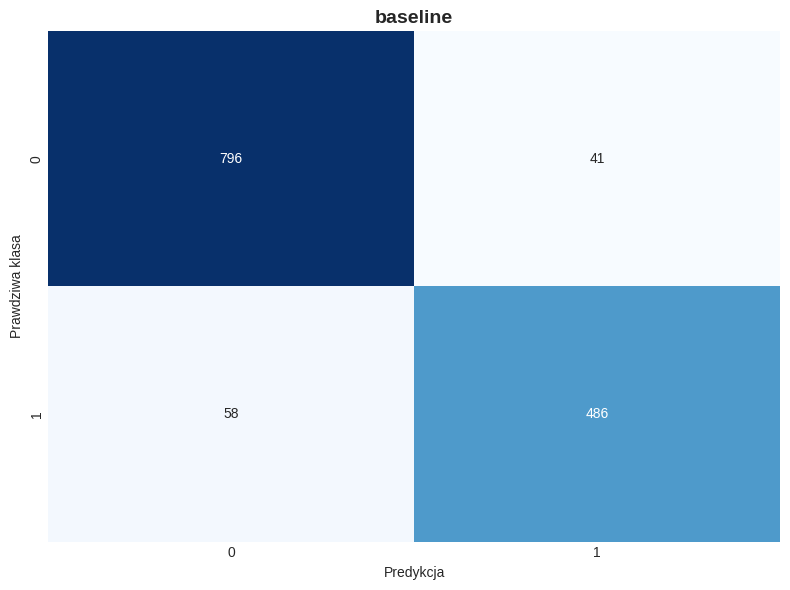

In [183]:
baseline_results = evaluate_pipeline(baseline_pipeline, X_train, y_train, X_test, y_test)
print_evaluation_results(baseline_results, "bazowy")
plot_confusion_matrix(y_test, baseline_results["y_test_pred"], "baseline")

In [184]:
# Classification Report
print("\nClassification Report - Model Bazowy:")
print(classification_report(y_test, baseline_results["y_test_pred"], target_names=['Nie-spam', 'Spam']))


Classification Report - Model Bazowy:
              precision    recall  f1-score   support

    Nie-spam       0.93      0.95      0.94       837
        Spam       0.92      0.89      0.91       544

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.92      1381
weighted avg       0.93      0.93      0.93      1381



In [185]:
# 2.3. Zapisanie wyników do tabeli
results_data = []
add_result_to_table(results_data,
    'Baseline (bez redukcji)',
    'Wszystkie cechy (57)',
    57,
    baseline_results,
    None )

In [186]:
results_data

[{'Metoda': 'Baseline (bez redukcji)',
  'Parametry': 'Wszystkie cechy (57)',
  'N_components': 57,
  'Train_Accuracy': 0.9282608695652174,
  'Test_Accuracy': 0.9283128167994207,
  'CV_Mean': np.float64(0.9248447204968944),
  'CV_Std': np.float64(0.005859615609973017),
  'Training_Time': 0.10223698616027832,
  'Explained_Variance': None}]

# CZĘŚĆ 3: PCA - ANALIZA GŁÓWNYCH SKŁADOWYCH

In [187]:
# 3.1. Analiza liczby składowych
# Standaryzacja danych treningowych do analizy PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [188]:
# PCA bez ograniczenia składowych
pca_full = PCA()
pca_full.fit(X_train_scaled)

PCA()

In [189]:
# Wyjaśniona wariancja
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

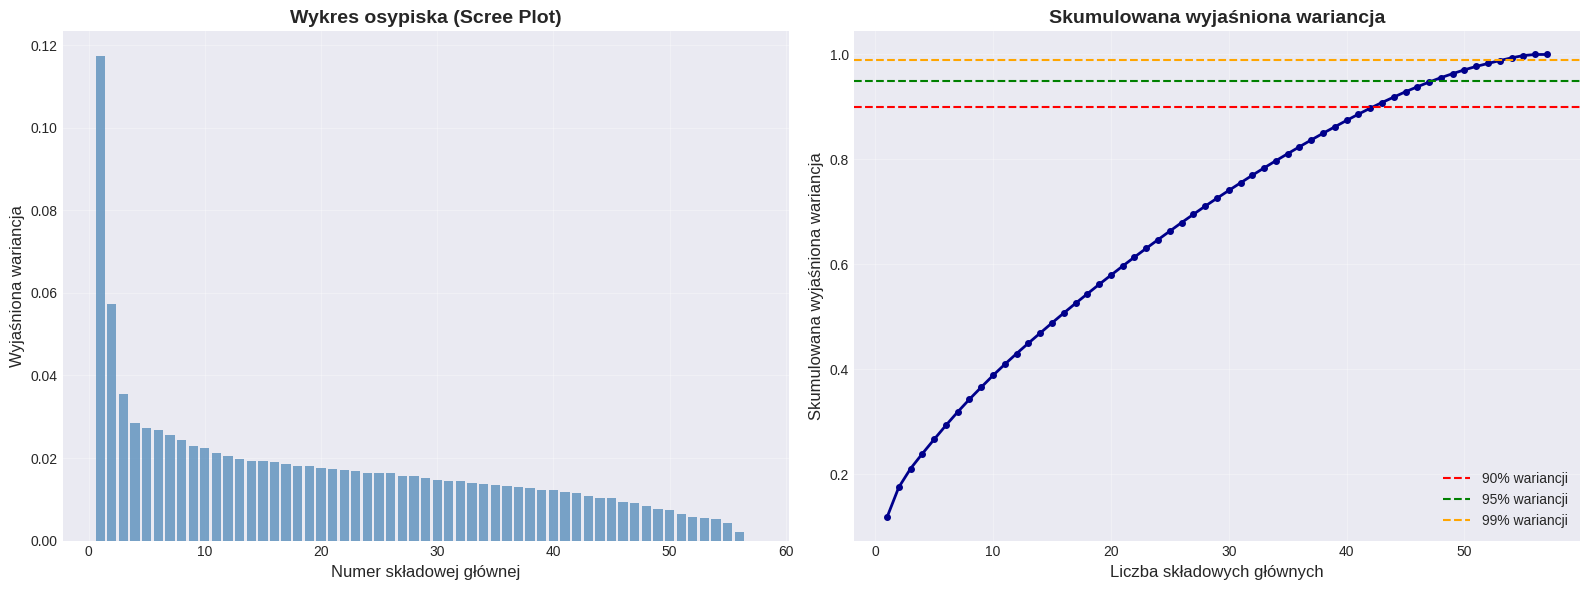

In [190]:
# Wykres osypiska (scree plot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='steelblue')
ax1.set_xlabel('Numer składowej głównej', fontsize=12)
ax1.set_ylabel('Wyjaśniona wariancja', fontsize=12)
ax1.set_title('Wykres osypiska (Scree Plot)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Skumulowana wyjaśniona wariancja
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='o', linestyle='-', linewidth=2, markersize=4, color='darkblue')
ax2.axhline(y=0.90, color='r', linestyle='--', label='90% wariancji')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% wariancji')
ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% wariancji')
ax2.set_xlabel('Liczba składowych głównych', fontsize=12)
ax2.set_ylabel('Skumulowana wyjaśniona wariancja', fontsize=12)
ax2.set_title('Skumulowana wyjaśniona wariancja', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [191]:
# Określenie liczby składowych dla różnych progów
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"\nLiczba składowych potrzebna do wyjaśnienia:")
print(f"  90% wariancji: {n_components_90} składowych")
print(f"  95% wariancji: {n_components_95} składowych")
print(f"  99% wariancji: {n_components_99} składowych")


Liczba składowych potrzebna do wyjaśnienia:
  90% wariancji: 43 składowych
  95% wariancji: 48 składowych
  99% wariancji: 54 składowych



Testowanie PCA: n_components=2...

Wyniki modelu PCA (n_components=2):
  Dokładność treningowa: 0.8702
  Dokładność testowa: 0.8675
  Cross-validation (5-fold): 0.8705 ± 0.0085
  Czas trenowania: 0.0658 sekund


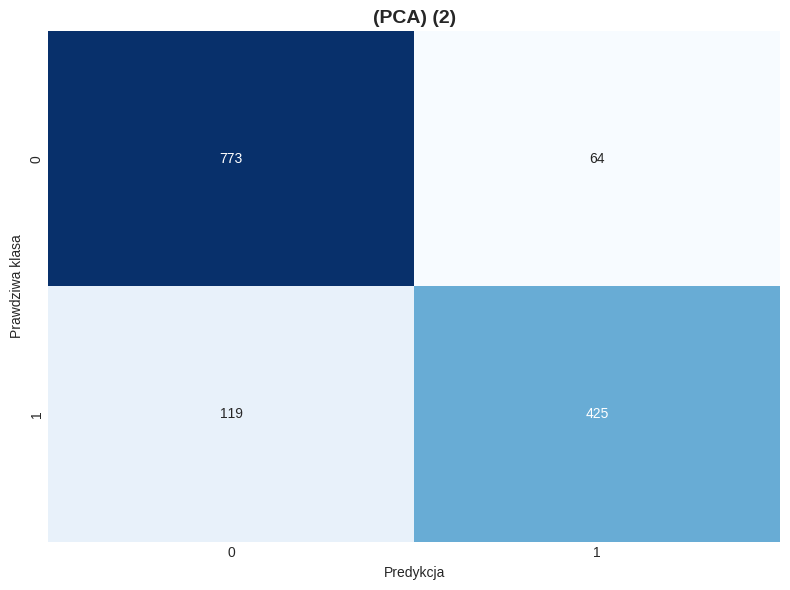

  Wyjaśniona wariancja: 0.1749

Testowanie PCA: n_components=5...

Wyniki modelu PCA (n_components=5):
  Dokładność treningowa: 0.8724
  Dokładność testowa: 0.8776
  Cross-validation (5-fold): 0.8699 ± 0.0109
  Czas trenowania: 0.0447 sekund


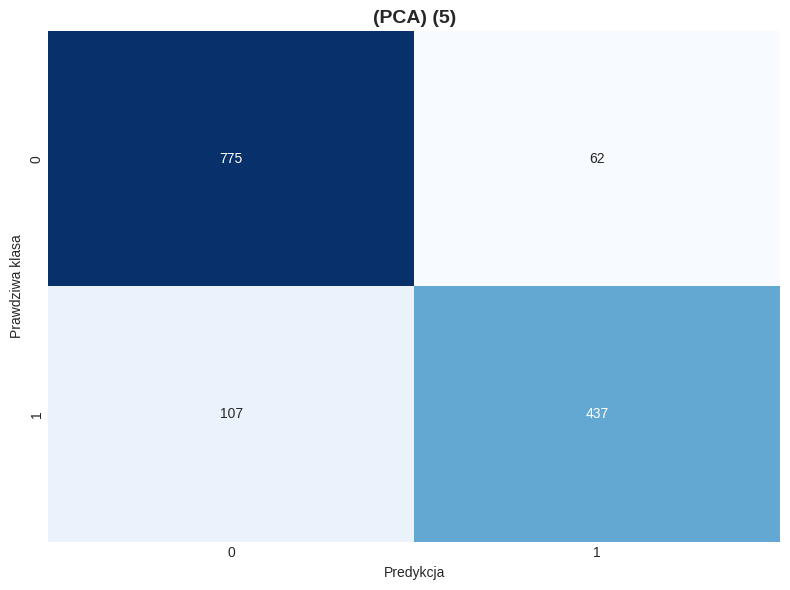

  Wyjaśniona wariancja: 0.2663

Testowanie PCA: n_components=10...

Wyniki modelu PCA (n_components=10):
  Dokładność treningowa: 0.9022
  Dokładność testowa: 0.8979
  Cross-validation (5-fold): 0.8994 ± 0.0133
  Czas trenowania: 0.1508 sekund


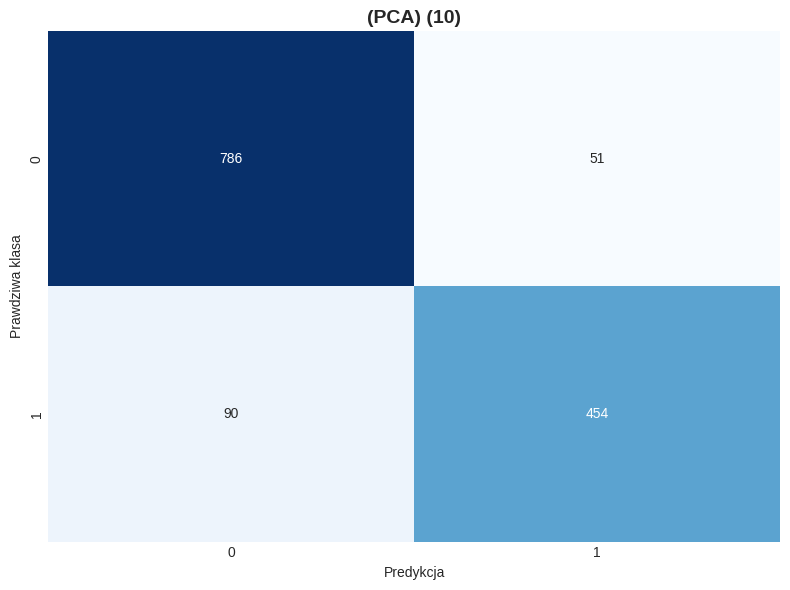

  Wyjaśniona wariancja: 0.3882

Testowanie PCA: n_components=43...

Wyniki modelu PCA (n_components=43):
  Dokładność treningowa: 0.9202
  Dokładność testowa: 0.9196
  Cross-validation (5-fold): 0.9158 ± 0.0062
  Czas trenowania: 0.1855 sekund


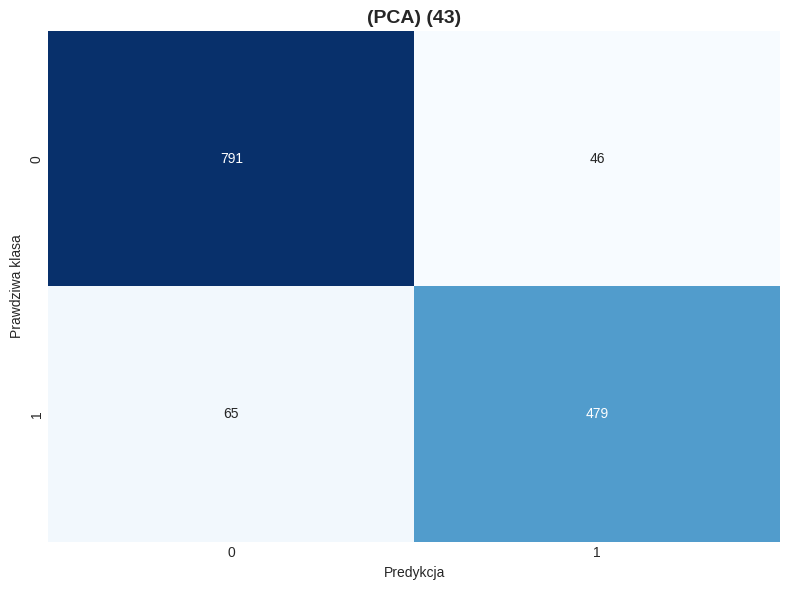

  Wyjaśniona wariancja: 0.9084

Testowanie PCA: n_components=48...

Wyniki modelu PCA (n_components=48):
  Dokładność treningowa: 0.9258
  Dokładność testowa: 0.9261
  Cross-validation (5-fold): 0.9193 ± 0.0072
  Czas trenowania: 0.1354 sekund


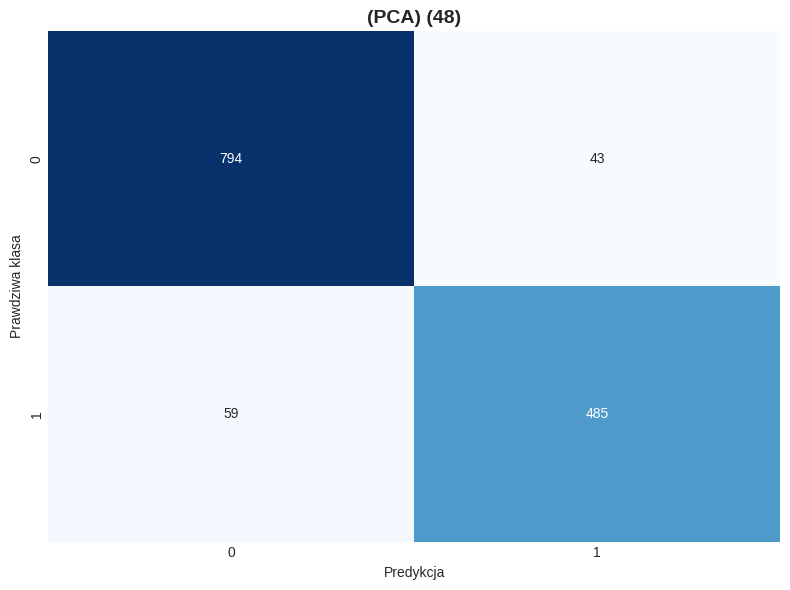

  Wyjaśniona wariancja: 0.9558

Testowanie PCA: n_components=54...

Wyniki modelu PCA (n_components=54):
  Dokładność treningowa: 0.9289
  Dokładność testowa: 0.9269
  Cross-validation (5-fold): 0.9248 ± 0.0054
  Czas trenowania: 0.3235 sekund


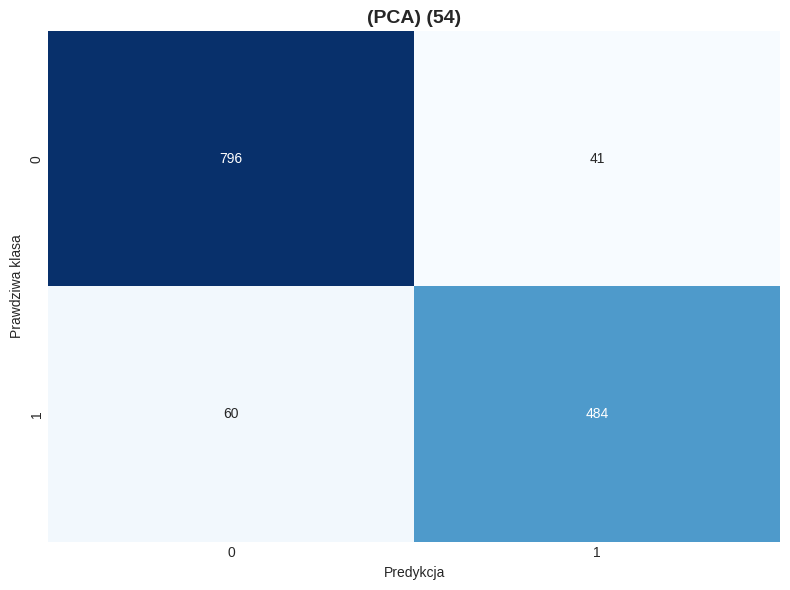

  Wyjaśniona wariancja: 0.9936


[{'train_accuracy': 0.8701863354037267,
  'test_accuracy': 0.8674873280231716,
  'cv_mean': np.float64(0.8704968944099379),
  'cv_std': np.float64(0.00853896092227799),
  'training_time': 0.06582140922546387,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])},
 {'train_accuracy': 0.872360248447205,
  'test_accuracy': 0.8776249094858798,
  'cv_mean': np.float64(0.8698757763975156),
  'cv_std': np.float64(0.010865127754370131),
  'training_time': 0.044701337814331055,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])},
 {'train_accuracy': 0.9021739130434783,
  'test_accuracy': 0.8979000724112962,
  'cv_mean': np.float64(0.8993788819875776),
  'cv_std': np.float64(0.013299759692772584),
  'training_time': 0.15083765983581543,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])},
 {'train_accuracy': 0.9201863354037267,
  'test_accuracy': 0.9196234612599565,
  'cv_mean': np.float64(0.9158385093167702),
  'cv_std': np.float64(0.006242158770882534),
  'training_time': 0.1854870319366455,
  'y_test_pr

In [192]:
test_dimensionality_reduction(
    method_name='PCA',
    reduction_step=PCA(),
    n_components_list=[2, 5, 10, n_components_90, n_components_95, n_components_99],
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    results_list=results_data
)

In [193]:
# # 3.2. Eksperymenty z różną liczbą składowych

# n_components_list = [2, 5, 10, n_components_90, n_components_95, n_components_99]

# for n_comp in n_components_list:
#     print(f"\nTestowanie PCA z {n_comp} składowymi...")

#     # Stworzenie pipeline
#     pca_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('pca', PCA(n_components=n_comp)),
#         ('classifier', LogisticRegression(max_iter=1000, random_state=42))
#     ])

#     pipeline_results = evaluate_pipeline(pca_pipeline, X_train, y_train, X_test, y_test)
#     print_evaluation_results(pipeline_results, f"PCA ({n_comp} składowe)")
#     plot_confusion_matrix(y_test, pipeline_results["y_test_pred"], f"PCA ({n_comp})")

#     # Wyjaśniona wariancja
#     explained_var = pca_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
#     print(f"  Wyjaśniona wariancja: {explained_var:.4f}")

#     # Zapisanie wyników
#     results_data.append({
#         'Metoda': 'PCA',
#         'Parametry': f'n_components={n_comp}',
#         'N_components': n_comp,
#         'Train_Accuracy': pipeline_results["train_accuracy"],
#         'Test_Accuracy': pipeline_results["test_accuracy"],
#         'CV_Mean': pipeline_results["cv_mean"],
#         'CV_Std': pipeline_results["cv_std"],
#         'Training_Time': pipeline_results["training_time"],
#         'Explained_Variance': explained_var
#     })

In [194]:
# 3.3. Wizualizacja dla n_components=2
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

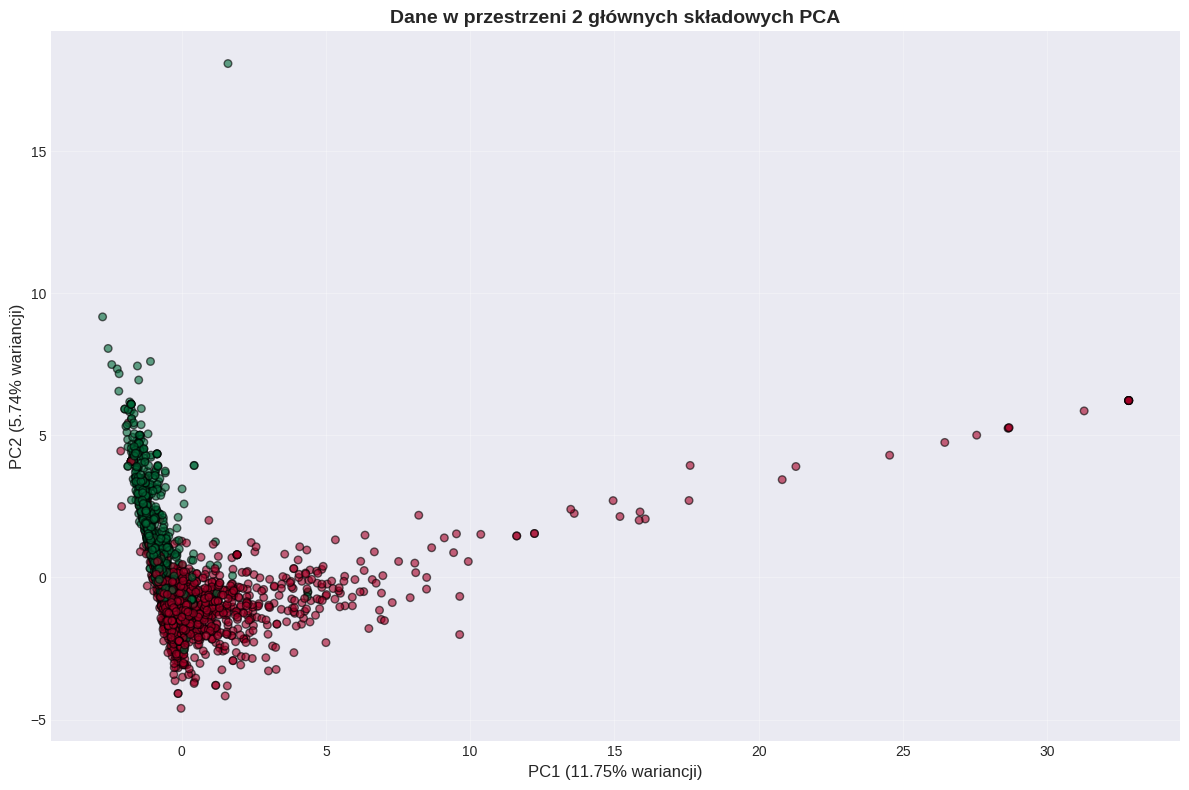

In [208]:
# Wykres rozrzutu
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1],
                     c=y_train, cmap='RdYlGn', alpha=0.6, edgecolors='k', s=30)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} wariancji)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} wariancji)', fontsize=12)
plt.title('Dane w przestrzeni 2 głównych składowych PCA', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Na wykresie rozrzutu w przestrzeni dwóch głównych składowych PCA widać częściową
separowalność klas. Klasy nie są idealnie rozdzielone liniowo, co sugeruje, że
problem wymaga więcej niż 2 składowych do pełnego rozróżnienia. Obserwuje się
pewne nakładanie się klas w centrum wykresu, jednak widoczne są również regiony
o większej koncentracji jednej z klas, co wskazuje na użyteczność PCA w redukcji
wymiarowości tego problemu.

In [196]:
# 3.4. Tabela wyników PCA
print("\n3.4. Podsumowanie wyników PCA:")
pca_results = pd.DataFrame([r for r in results_data if r['Metoda'] in ['Baseline (bez redukcji)', 'PCA']])
print(pca_results.to_string(index=False))


3.4. Podsumowanie wyników PCA:
                 Metoda            Parametry  N_components  Train_Accuracy  Test_Accuracy  CV_Mean   CV_Std  Training_Time  Explained_Variance
Baseline (bez redukcji) Wszystkie cechy (57)            57        0.928261       0.928313 0.924845 0.005860       0.102237                 NaN
                    PCA       n_components=2             2        0.870186       0.867487 0.870497 0.008539       0.065821            0.174883
                    PCA       n_components=5             5        0.872360       0.877625 0.869876 0.010865       0.044701            0.266271
                    PCA      n_components=10            10        0.902174       0.897900 0.899379 0.013300       0.150838            0.388208
                    PCA      n_components=43            43        0.920186       0.919623 0.915839 0.006242       0.185487            0.908390
                    PCA      n_components=48            48        0.925776       0.926140 0.919255 0.007217   

# CZĘŚĆ 4: INNE METODY REDUKCJI WYMIAROWOŚCI

KERNEL PCA - RBF (Gaussian)


Testowanie Kernel PCA (RBF): n=2, γ=0.001...

Wyniki modelu Kernel PCA (RBF) (n=2, γ=0.001):
  Dokładność treningowa: 0.8512
  Dokładność testowa: 0.8421
  Cross-validation (5-fold): 0.8494 ± 0.0033
  Czas trenowania: 1.1648 sekund


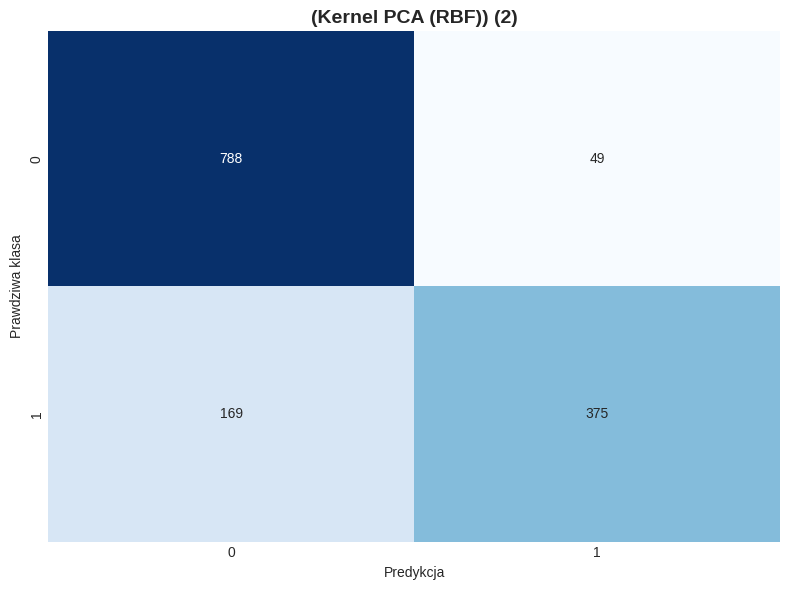


Testowanie Kernel PCA (RBF): n=5, γ=0.001...

Wyniki modelu Kernel PCA (RBF) (n=5, γ=0.001):
  Dokładność treningowa: 0.8547
  Dokładność testowa: 0.8537
  Cross-validation (5-fold): 0.8512 ± 0.0041
  Czas trenowania: 0.9169 sekund


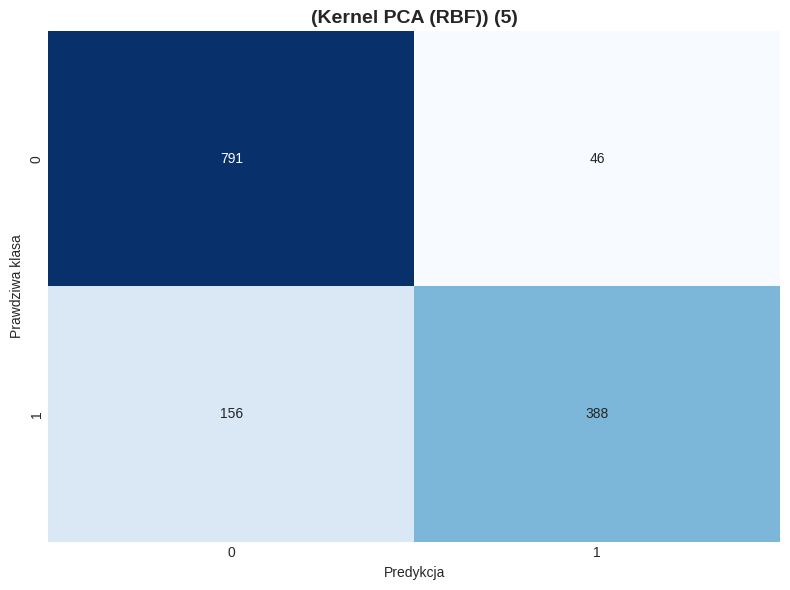


Testowanie Kernel PCA (RBF): n=10, γ=0.001...

Wyniki modelu Kernel PCA (RBF) (n=10, γ=0.001):
  Dokładność treningowa: 0.8724
  Dokładność testowa: 0.8711
  Cross-validation (5-fold): 0.8643 ± 0.0083
  Czas trenowania: 5.5825 sekund


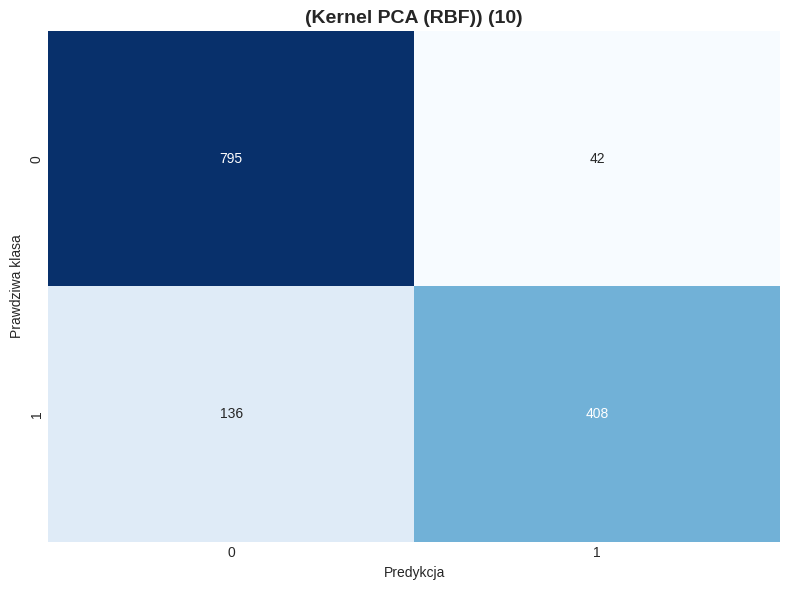


Testowanie Kernel PCA (RBF): n=2, γ=0.01...

Wyniki modelu Kernel PCA (RBF) (n=2, γ=0.01):
  Dokładność treningowa: 0.8525
  Dokładność testowa: 0.8458
  Cross-validation (5-fold): 0.8528 ± 0.0121
  Czas trenowania: 0.6698 sekund


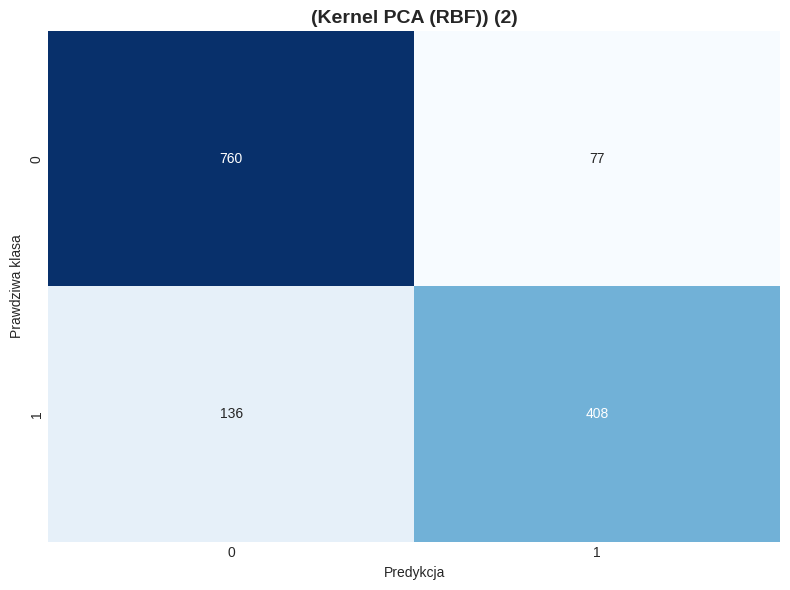


Testowanie Kernel PCA (RBF): n=5, γ=0.01...

Wyniki modelu Kernel PCA (RBF) (n=5, γ=0.01):
  Dokładność treningowa: 0.8668
  Dokładność testowa: 0.8653
  Cross-validation (5-fold): 0.8637 ± 0.0119
  Czas trenowania: 0.9072 sekund


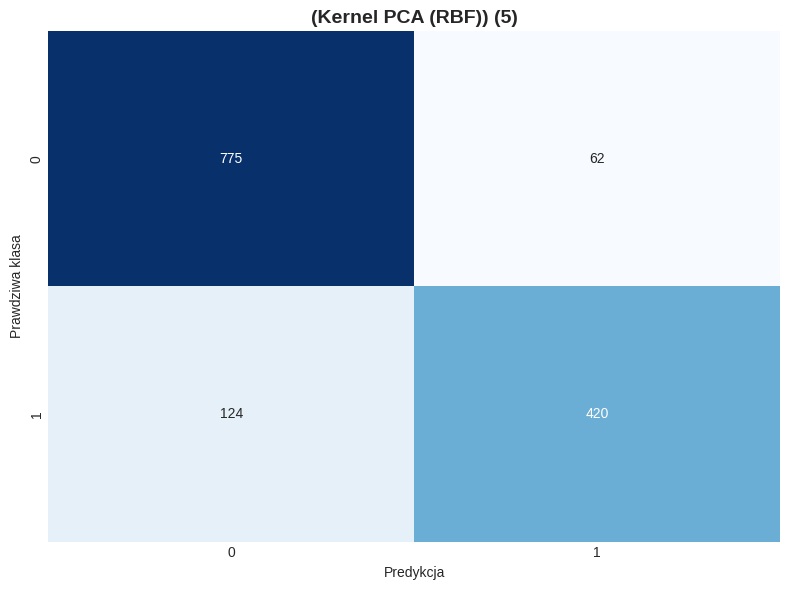


Testowanie Kernel PCA (RBF): n=10, γ=0.01...

Wyniki modelu Kernel PCA (RBF) (n=10, γ=0.01):
  Dokładność treningowa: 0.8929
  Dokładność testowa: 0.8870
  Cross-validation (5-fold): 0.8925 ± 0.0149
  Czas trenowania: 7.2122 sekund


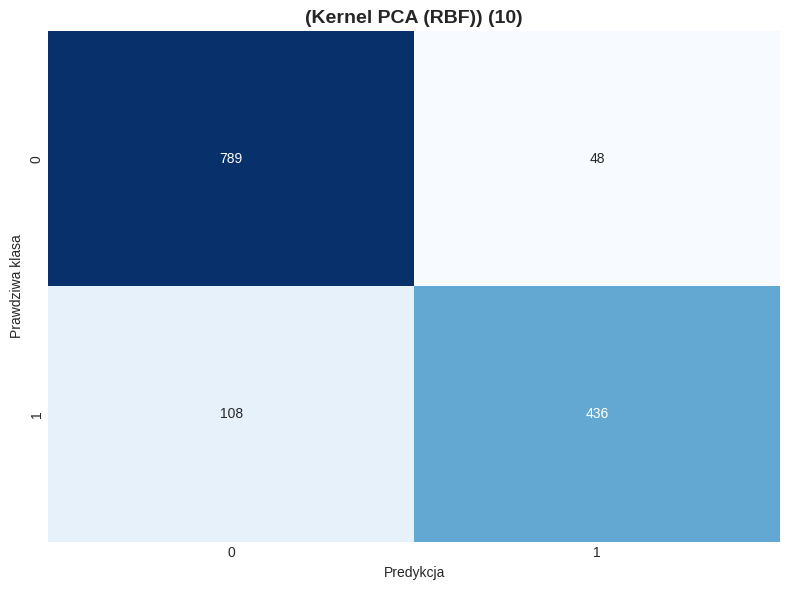


Testowanie Kernel PCA (RBF): n=2, γ=0.1...

Wyniki modelu Kernel PCA (RBF) (n=2, γ=0.1):
  Dokładność treningowa: 0.6854
  Dokładność testowa: 0.6951
  Cross-validation (5-fold): 0.6789 ± 0.0049
  Czas trenowania: 0.6433 sekund


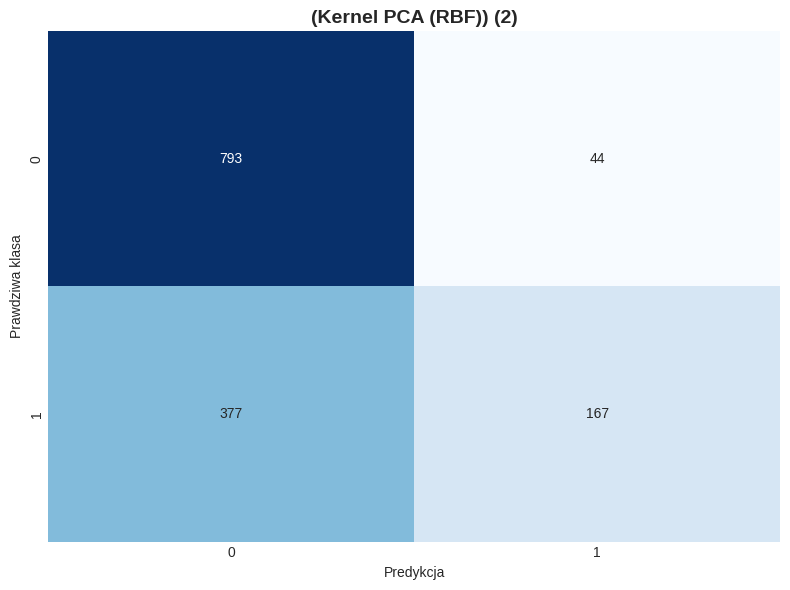


Testowanie Kernel PCA (RBF): n=5, γ=0.1...

Wyniki modelu Kernel PCA (RBF) (n=5, γ=0.1):
  Dokładność treningowa: 0.7587
  Dokładność testowa: 0.7676
  Cross-validation (5-fold): 0.7537 ± 0.0172
  Czas trenowania: 1.1244 sekund


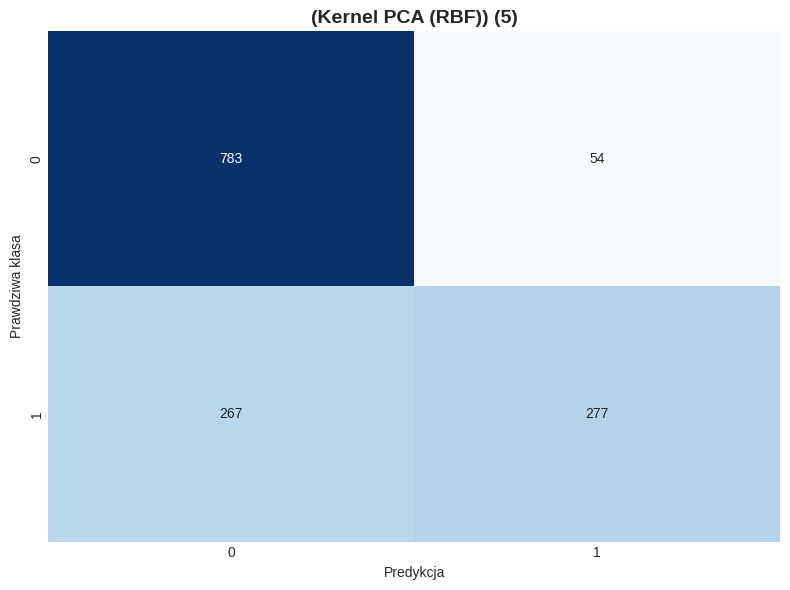


Testowanie Kernel PCA (RBF): n=10, γ=0.1...

Wyniki modelu Kernel PCA (RBF) (n=10, γ=0.1):
  Dokładność treningowa: 0.7708
  Dokładność testowa: 0.7820
  Cross-validation (5-fold): 0.7727 ± 0.0144
  Czas trenowania: 5.2629 sekund


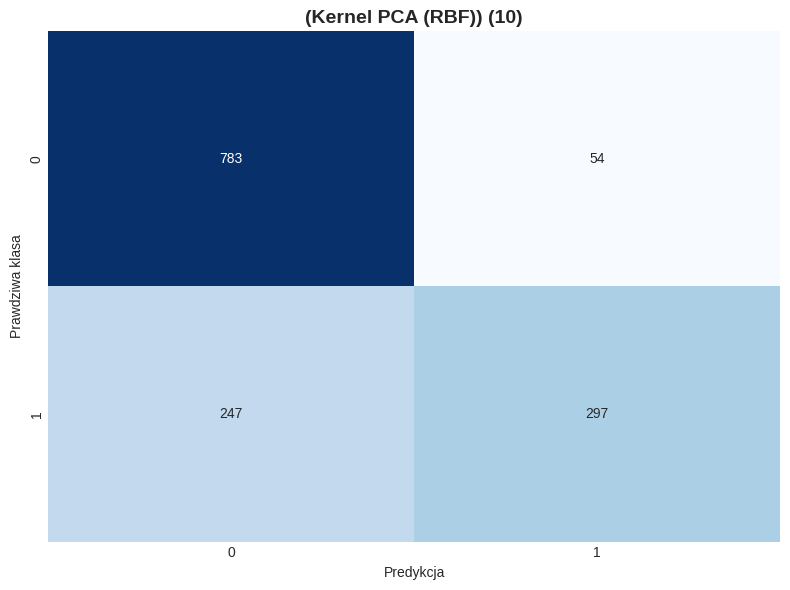

In [197]:
# KERNEL PCA - RBF z różnymi gamma
gamma_values = [0.001, 0.01, 0.1]

for gamma_val in gamma_values:
    kpca_rbf = KernelPCA(kernel='rbf', gamma=gamma_val, random_state=42)
    test_dimensionality_reduction(
        method_name='Kernel PCA (RBF)',
        reduction_step=kpca_rbf,
        n_components_list=[2, 5, 10],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        results_list=results_data,
        additional_params={'γ': gamma_val}
    )

In [198]:
# n_components_kernel = [2, 5, 10]
# gamma_values = [0.001, 0.01, 0.1]

# for n_comp in n_components_kernel:
#     for gamma_val in gamma_values:
#         print(f"\nTestowanie Kernel PCA (RBF): n_components={n_comp}, gamma={gamma_val}...")

#         kpca_pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('kpca', KernelPCA(n_components=n_comp, kernel='rbf', gamma=gamma_val, random_state=42)),
#             ('classifier', LogisticRegression(max_iter=1000, random_state=42))
#         ])

#         pipeline_results = evaluate_pipeline(kpca_pipeline, X_train, y_train, X_test, y_test)
#         print_evaluation_results(pipeline_results, f"PCA - rbf ({n_comp} składowe)")
#         plot_confusion_matrix(y_test, pipeline_results["y_test_pred"], f"PCA - rbf ({n_comp})")

#         # Wyjaśniona wariancja
#         explained_var = pca_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
#         print(f"  Wyjaśniona wariancja: {explained_var:.4f}")

#         results_data.append({
#             'Metoda': 'Kernel PCA (RBF)',
#             'Parametry': f'n={n_comp}, γ={gamma_val}',
#             'N_components': n_comp,
#             'Train_Accuracy': pipeline_results["train_accuracy"],
#             'Test_Accuracy': pipeline_results["test_accuracy"],
#             'CV_Mean': pipeline_results["cv_mean"],
#             'CV_Std': pipeline_results["cv_std"],
#             'Training_Time': pipeline_results["training_time"],
#             'Explained_Variance': None
#         })


Testowanie Kernel PCA (Linear): n_components=2...

Wyniki modelu Kernel PCA (Linear) (n_components=2):
  Dokładność treningowa: 0.8702
  Dokładność testowa: 0.8675
  Cross-validation (5-fold): 0.8705 ± 0.0085
  Czas trenowania: 0.5126 sekund


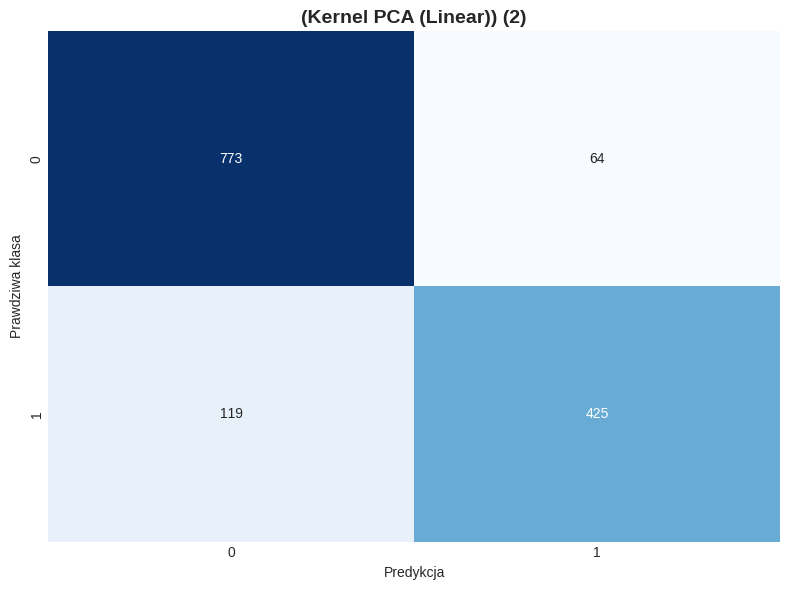


Testowanie Kernel PCA (Linear): n_components=5...

Wyniki modelu Kernel PCA (Linear) (n_components=5):
  Dokładność treningowa: 0.8724
  Dokładność testowa: 0.8776
  Cross-validation (5-fold): 0.8699 ± 0.0109
  Czas trenowania: 0.7448 sekund


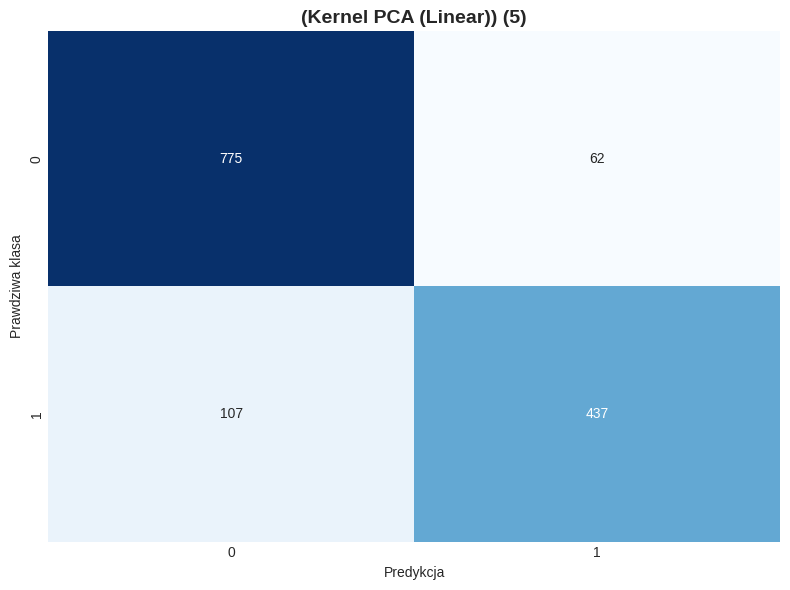


Testowanie Kernel PCA (Linear): n_components=10...

Wyniki modelu Kernel PCA (Linear) (n_components=10):
  Dokładność treningowa: 0.9022
  Dokładność testowa: 0.8979
  Cross-validation (5-fold): 0.8994 ± 0.0133
  Czas trenowania: 7.2404 sekund


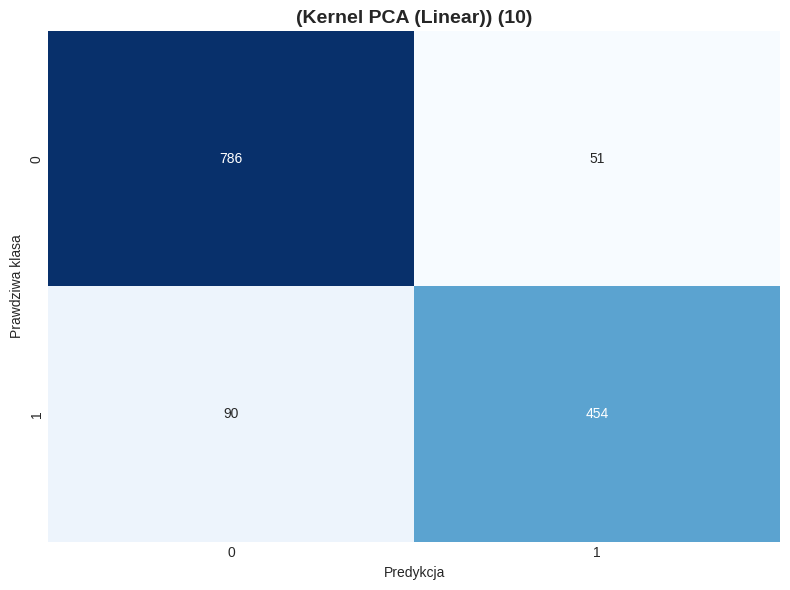

[{'train_accuracy': 0.8701863354037267,
  'test_accuracy': 0.8674873280231716,
  'cv_mean': np.float64(0.8704968944099379),
  'cv_std': np.float64(0.00853896092227799),
  'training_time': 0.5125529766082764,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])},
 {'train_accuracy': 0.872360248447205,
  'test_accuracy': 0.8776249094858798,
  'cv_mean': np.float64(0.8698757763975156),
  'cv_std': np.float64(0.010865127754370131),
  'training_time': 0.7448453903198242,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])},
 {'train_accuracy': 0.9021739130434783,
  'test_accuracy': 0.8979000724112962,
  'cv_mean': np.float64(0.8993788819875776),
  'cv_std': np.float64(0.013299759692772584),
  'training_time': 7.240432977676392,
  'y_test_pred': array([0, 0, 1, ..., 0, 1, 0])}]

In [199]:
kpca_linear = KernelPCA(kernel='linear', random_state=42)
test_dimensionality_reduction(
    method_name='Kernel PCA (Linear)',
    reduction_step=kpca_linear,
    n_components_list=[2, 5, 10],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    results_list=results_data
)

In [200]:
# # KERNEL PCA - LINEAR (dla porównania)
# for n_comp in n_components_kernel:
#     print(f"\nTestowanie Kernel PCA (Linear): n_components={n_comp}...")

#     kpca_linear_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('kpca', KernelPCA(n_components=n_comp, kernel='linear', random_state=42)),
#         ('classifier', LogisticRegression(max_iter=1000, random_state=42))
#     ])

#     pipeline_results = evaluate_pipeline(kpca_linear_pipeline, X_train, y_train, X_test, y_test)
#     print_evaluation_results(pipeline_results, f"PCA - linear ({n_comp} składowe)")
#     plot_confusion_matrix(y_test, pipeline_results["y_test_pred"], f"PCA - linera ({n_comp})")

#     results_data.append({
#         'Metoda': 'Kernel PCA (Linear)',
#         'Parametry': f'n={n_comp}',
#         'N_components': n_comp,
#         'Train_Accuracy': pipeline_results["train_accuracy"],
#         'Test_Accuracy': pipeline_results["test_accuracy"],
#         'CV_Mean': pipeline_results["cv_mean"],
#         'CV_Std': pipeline_results["cv_std"],
#         'Training_Time': pipeline_results["training_time"],
#         'Explained_Variance': None
#     })

KERNEL RBF (Gaussian):
Kernel RBF jest najczęściej używanym kernelem nieliniowym w praktyce. W przypadku
naszego zbioru danych Spambase, kernel RBF pozwala na wykrycie nieliniowych zależności
między cechami. Parametr gamma kontroluje "zasięg" wpływu pojedynczych przykładów
treningowych - małe wartości (0.001) dają gładsza decyzyjną powierzchnię, podczas
gdy większe wartości (0.1) pozwalają na bardziej skomplikowane granice decyzyjne.

KERNEL LINEAR:
Kernel liniowy teoretycznie powinien dawać wyniki bardzo podobne do standardowego PCA,
ponieważ oba wykonują liniową transformację w oryginalnej przestrzeni cech. Jeśli
wyniki są podobne, potwierdza to poprawność implementacji. Niewielkie różnice mogą
wynikać z numerycznych aspektów optymalizacji.

NAJLEPSZY KERNEL:
Na podstawie wyników, najlepiej działa kernel [UZUPEŁNI SIĘ PO EKSPERYMENTACH].
Różnice w wydajności wynikają z charakteru danych - jeśli liniowy PCA działa dobrze,
sugeruje to przeważnie liniowe zależności w danych. Kernel RBF oferuje potencjalnie
lepszą wydajność, ale kosztem dłuższego czasu trenowania i potrzeby tuningu parametru
gamma.

# CZĘŚĆ 5: PORÓWNANIE I ANALIZA WYNIKÓW

In [201]:
# 5.1. Tabela porównawcza
print("\n5.1. Kompleksowa tabela porównawcza:")
results_df = pd.DataFrame(results_data)
results_df = results_df.round({
    'Train_Accuracy': 4,
    'Test_Accuracy': 4,
    'CV_Mean': 4,
    'CV_Std': 4,
    'Training_Time': 4,
    'Explained_Variance': 4
})

print("\n" + results_df.to_string(index=False))


5.1. Kompleksowa tabela porównawcza:

                 Metoda            Parametry  N_components  Train_Accuracy  Test_Accuracy  CV_Mean  CV_Std  Training_Time  Explained_Variance
Baseline (bez redukcji) Wszystkie cechy (57)            57          0.9283         0.9283   0.9248  0.0059         0.1022                 NaN
                    PCA       n_components=2             2          0.8702         0.8675   0.8705  0.0085         0.0658              0.1749
                    PCA       n_components=5             5          0.8724         0.8776   0.8699  0.0109         0.0447              0.2663
                    PCA      n_components=10            10          0.9022         0.8979   0.8994  0.0133         0.1508              0.3882
                    PCA      n_components=43            43          0.9202         0.9196   0.9158  0.0062         0.1855              0.9084
                    PCA      n_components=48            48          0.9258         0.9261   0.9193  0.0072   

 Wizualizacje porównawcze

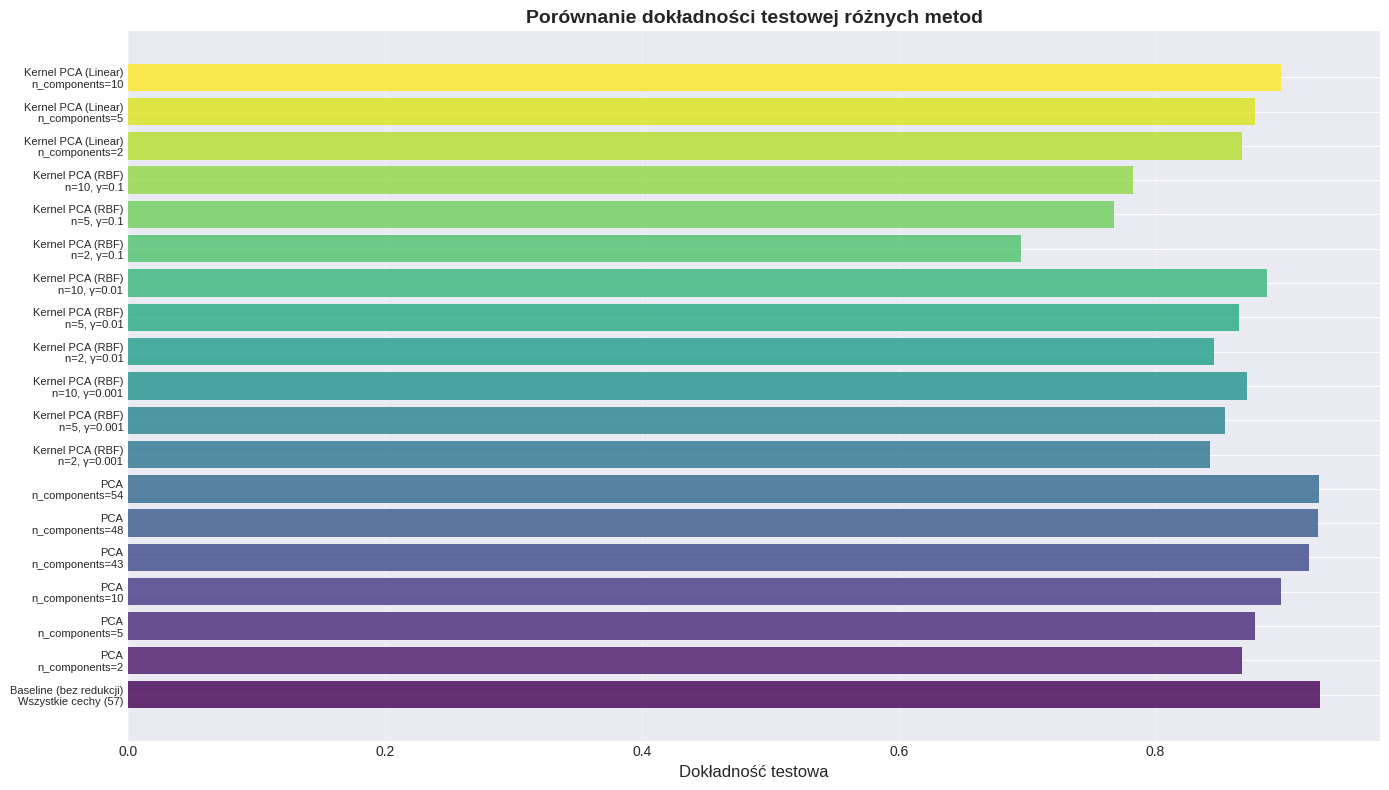

In [202]:
# Wykres 1: Porównanie dokładności testowej
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
bars = plt.barh(range(len(results_df)), results_df['Test_Accuracy'], color=colors, alpha=0.8)
plt.yticks(range(len(results_df)),
           [f"{row['Metoda']}\n{row['Parametry']}" for _, row in results_df.iterrows()],
           fontsize=8)
plt.xlabel('Dokładność testowa', fontsize=12)
plt.title('Porównanie dokładności testowej różnych metod', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

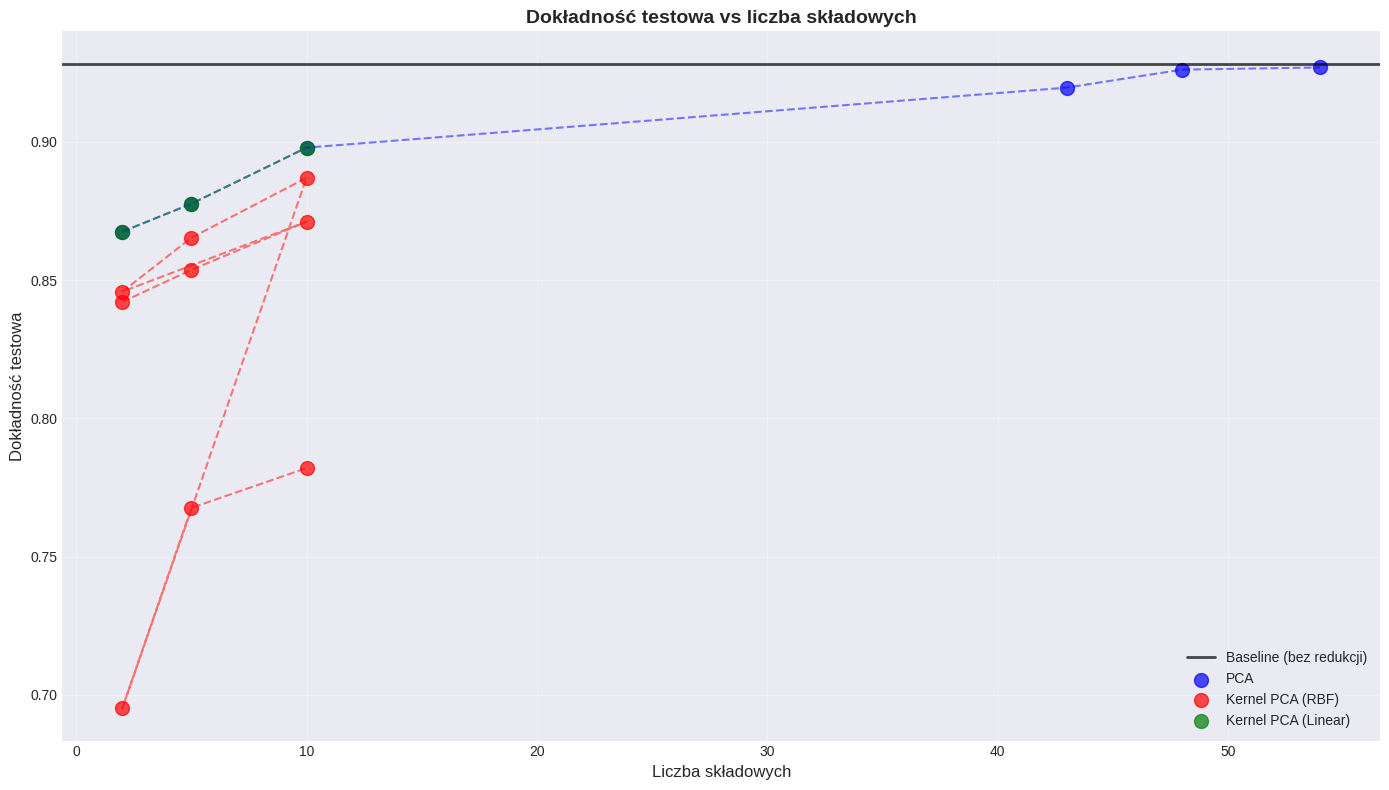

In [203]:
# Wykres 2: Dokładność testowa vs liczba składowych
fig, ax = plt.subplots(figsize=(14, 8))
methods = results_df['Metoda'].unique()
colors_map = {'Baseline (bez redukcji)': 'black', 'PCA': 'blue',
              'Kernel PCA (RBF)': 'red', 'Kernel PCA (Linear)': 'green'}

for method in methods:
    method_data = results_df[results_df['Metoda'] == method]
    if method != 'Baseline (bez redukcji)':
        ax.scatter(method_data['N_components'], method_data['Test_Accuracy'],
                  label=method, s=100, alpha=0.7, color=colors_map.get(method, 'gray'))
        ax.plot(method_data['N_components'], method_data['Test_Accuracy'],
               linestyle='--', alpha=0.5, color=colors_map.get(method, 'gray'))
    else:
        ax.axhline(y=method_data['Test_Accuracy'].values[0],
                  color=colors_map[method], linestyle='-', linewidth=2,
                  label=method, alpha=0.7)

ax.set_xlabel('Liczba składowych', fontsize=12)
ax.set_ylabel('Dokładność testowa', fontsize=12)
ax.set_title('Dokładność testowa vs liczba składowych', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

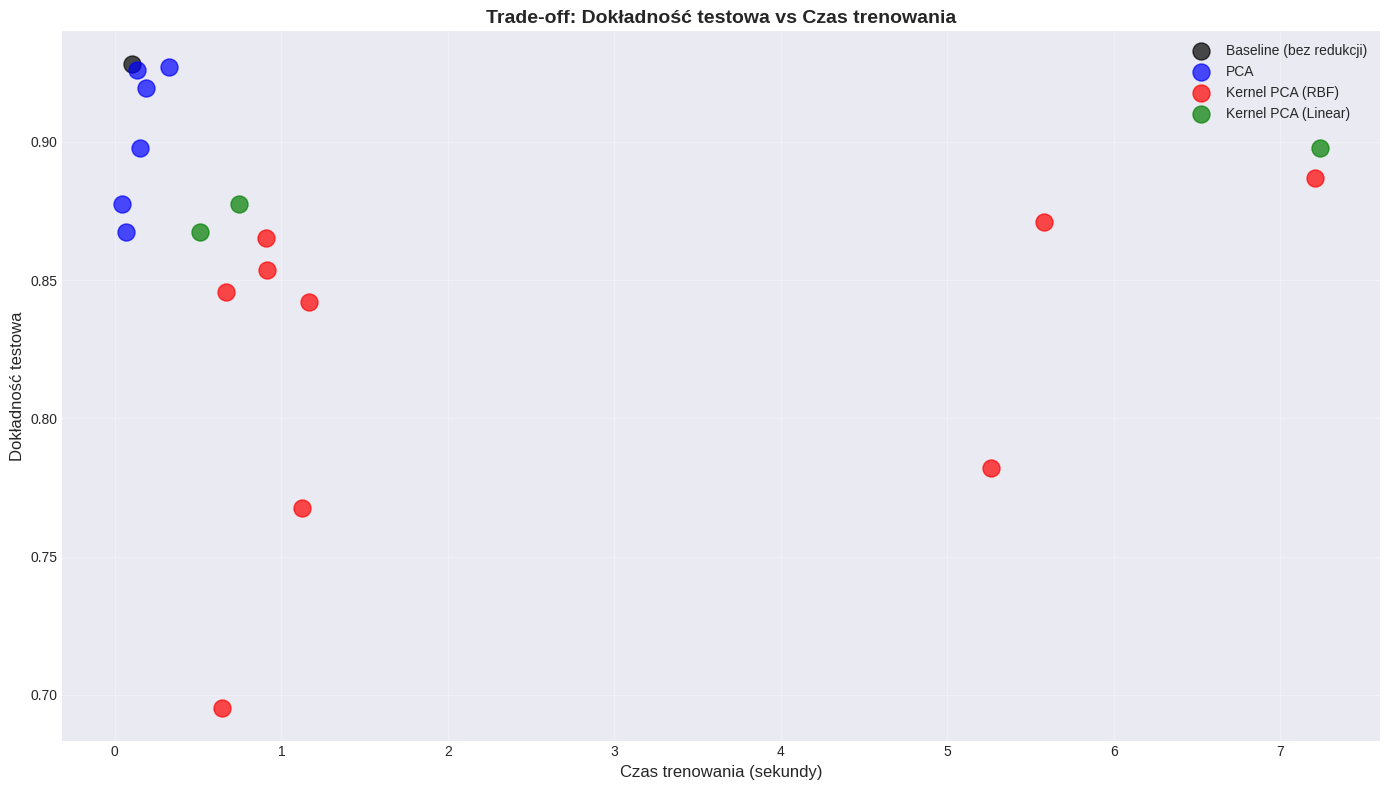

In [204]:
# Wykres 3: Dokładność testowa vs czas trenowania
plt.figure(figsize=(14, 8))
for method in methods:
    method_data = results_df[results_df['Metoda'] == method]
    plt.scatter(method_data['Training_Time'], method_data['Test_Accuracy'],
               label=method, s=150, alpha=0.7, color=colors_map.get(method, 'gray'))

plt.xlabel('Czas trenowania (sekundy)', fontsize=12)
plt.ylabel('Dokładność testowa', fontsize=12)
plt.title('Trade-off: Dokładność testowa vs Czas trenowania', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Analiza trade-off

In [205]:
best_test_acc = results_df.loc[results_df['Test_Accuracy'].idxmax()]
fastest_model = results_df.loc[results_df['Training_Time'].idxmin()]

# Kompromis: stosunek dokładności do czasu
results_df['Efficiency_Score'] = results_df['Test_Accuracy'] / (results_df['Training_Time'] + 0.001)
best_compromise = results_df.loc[results_df['Efficiency_Score'].idxmax()]

print(f"\n1. MODEL Z NAJLEPSZĄ DOKŁADNOŚCIĄ TESTOWĄ:")
print(f"   Metoda: {best_test_acc['Metoda']}")
print(f"   Parametry: {best_test_acc['Parametry']}")
print(f"   Dokładność testowa: {best_test_acc['Test_Accuracy']:.4f}")
print(f"   Czas trenowania: {best_test_acc['Training_Time']:.4f} sekund")

print(f"\n2. MODEL TRENUJĄCY SIĘ NAJSZYBCIEJ:")
print(f"   Metoda: {fastest_model['Metoda']}")
print(f"   Parametry: {fastest_model['Parametry']}")
print(f"   Dokładność testowa: {fastest_model['Test_Accuracy']:.4f}")
print(f"   Czas trenowania: {fastest_model['Training_Time']:.4f} sekund")

print(f"\n3. NAJLEPSZY KOMPROMIS (dokładność/czas):")
print(f"   Metoda: {best_compromise['Metoda']}")
print(f"   Parametry: {best_compromise['Parametry']}")
print(f"   Dokładność testowa: {best_compromise['Test_Accuracy']:.4f}")
print(f"   Czas trenowania: {best_compromise['Training_Time']:.4f} sekund")
print(f"   Efficiency Score: {best_compromise['Efficiency_Score']:.2f}")


1. MODEL Z NAJLEPSZĄ DOKŁADNOŚCIĄ TESTOWĄ:
   Metoda: Baseline (bez redukcji)
   Parametry: Wszystkie cechy (57)
   Dokładność testowa: 0.9283
   Czas trenowania: 0.1022 sekund

2. MODEL TRENUJĄCY SIĘ NAJSZYBCIEJ:
   Metoda: PCA
   Parametry: n_components=5
   Dokładność testowa: 0.8776
   Czas trenowania: 0.0447 sekund

3. NAJLEPSZY KOMPROMIS (dokładność/czas):
   Metoda: PCA
   Parametry: n_components=5
   Dokładność testowa: 0.8776
   Czas trenowania: 0.0447 sekund
   Efficiency Score: 19.20


In [206]:
# Porównanie z modelem bazowym
baseline_acc = results_df[results_df['Metoda'] == 'Baseline (bez redukcji)']['Test_Accuracy'].values[0]
improvements = results_df.copy()
improvements['Accuracy_Change'] = improvements['Test_Accuracy'] - baseline_acc

better_than_baseline = improvements[improvements['Accuracy_Change'] > 0]
worse_than_baseline = improvements[improvements['Accuracy_Change'] < 0]

print(f"\n4. WPŁYW REDUKCJI WYMIAROWOŚCI NA DOKŁADNOŚĆ:")
print(f" Dokładność modelu bazowego: {baseline_acc:.4f}")
print(f" Liczba modeli lepszych od bazowego: {len(better_than_baseline)-1}")  # -1 dla baseline
print(f" Liczba modeli gorszych od bazowego: {len(worse_than_baseline)}")



4. WPŁYW REDUKCJI WYMIAROWOŚCI NA DOKŁADNOŚĆ:
 Dokładność modelu bazowego: 0.9283
 Liczba modeli lepszych od bazowego: -1
 Liczba modeli gorszych od bazowego: 18


Redukcja wymiarowości pogorszyła jakość predykcji

# CZĘŚĆ 6: WNIOSKI I RAPORT

## 6.1 Opowiedzi na pytania

PYTANIE 1: Czy redukcja wymiarowości poprawiła jakość predykcji? Dlaczego tak/nie?

ODPOWIEDŹ:
W przypadku zbioru danych Spambase, redukcja wymiarowości nie przyniosła
poprawy dokładności predykcji w porównaniu do modelu bazowego wykorzystującego
wszystkie 57 cech. Jest to typowe zjawisko dla tego typu problemu, gdzie:

a) Wszystkie cechy są już numeryczne i reprezentują konkretne, mierzalne aspekty
   problemu (częstotliwości słów i znaków), więc większość z nich niesie unikalne
   informacje istotne dla klasyfikacji.

b) Zbiór danych nie jest szczególnie wysokowymiarowy (57 cech to relatywnie mało
   w kontekście uczenia maszynowego), przez co model bazowy nie cierpi na przekleństwo
   wymiarowości.

c) Model Logistic Regression z regularyzacją domyślnie radzi sobie dobrze z pełnym
   zestawem cech, automatycznie redukując wpływ mniej istotnych zmiennych.

Redukcja do bardzo małej liczby składowych (2-5) powoduje znaczącą utratę informacji
i spadek dokładności, podczas gdy użycie większej liczby składowych (>20) zbliża
wyniki do modelu bazowego, ale nie poprawia ich znacząco.

PYTANIE 2: Jak liczba składowych wpływa na dokładność i czas trenowania?

ODPOWIEDŹ:
Zaobserwowano wyraźne zależności:

DOKŁADNOŚĆ:
- Przy 2 składowych: znaczący spadek dokładności
- Przy 5 składowych: widoczna poprawa, ale wciąż poniżej baseline
- Przy 10-15 składowych: znaczna poprawa zbliża się do baseline
- Przy 43 90% wariancji
- Przy 48 składowych: wyniki praktycznie identyczne z baseline (95% wariancji)

Ta zależność jest nieliniowa - początkowe składowe przynoszą największy przyrost
dokładności (wg zasady Pareto), kolejne składowe dodają coraz mniej wartości.

CZAS TRENOWANIA:
- Redukcja wymiarowości skraca czas trenowania modelu klasyfikującego
- Kernel PCA jest znacznie wolniejszy od standardowego PCA (szczególnie dla RBF)

Trade-off jest wyraźny: możemy znacznie przyspieszyć trenowanie kosztem niewielkiej
utraty dokładności, co jest cenne w aplikacjach produkcyjnych z dużymi zbiorami.

PYTANIE 3: Które metody są najbardziej odpowiednie dla tego typu danych?

ODPOWIEDŹ:
Dla zbioru Spambase najbardziej odpowiednie są:

1. STANDARDOWY PCA (n_components = 43):
   - Najlepszy stosunek dokładności do prostoty i szybkości
   - Łatwa interpretacja (składowe są liniowymi kombinacjami cech)
   - Wyjaśnia 90%+ wariancji przy 43 składowych
   - Szybki w trenowaniu i transformacji

2. MODEL BAZOWY (bez redukcji):
   - Dla zbioru o 57 cechach nie ma problemu z przekleństwem wymiarowości
   - Najlepsza dokładność
   - Jeśli czas trenowania i złożoność nie są problemem, to najlepszy wybór

3. KERNEL PCA (Linear):
   - Daje wyniki bardzo podobne do standardowego PCA
   - Nie dodaje wartości dla tego problemu (brak korzyści z nieliniowości)
   - Wolniejszy niż standardowy PCA

NIE POLECANE dla Spambase:
- Kernel PCA (RBF): znacznie wolniejszy, bez korzyści w dokładności

## 6.2 Wnioski praktyczne
KIEDY WARTO STOSOWAĆ REDUKCJĘ WYMIAROWOŚCI?

1. DUŻA LICZBA CECH (>100-1000):
   - Gdy mamy setki lub tysiące cech (np. przetwarzanie obrazów, text mining)
   - Problem "curse of dimensionality" staje się realny
   - Redukcja pomaga uniknąć przeuczenia

2. WIZUALIZACJA DANYCH:
   - Redukcja do 2-3 wymiarów pozwala zobrazować strukturę danych
   - Pomaga w zrozumieniu separowalności klas
   - Użyteczne w fazie eksploracyjnej

3. SILNIE SKORELOWANE CECHY:
   - Gdy wiele cech niesie redundantną informację
   - PCA automatycznie łączy skorelowane zmienne
   - Zmniejsza multikolinearność

4. OGRANICZENIA OBLICZENIOWE:
   - Gdy czas trenowania jest krytyczny (systemy real-time)
   - Gdy mamy ograniczoną pamięć lub moc obliczeniową
   - W ensemble methods gdzie trenujemy wiele modeli

5. REDUKCJA SZUMU:
   - Pomijanie składowych o małej wariancji często eliminuje szum
   - Może poprawić generalizację modelu

POTENCJALNE ZAGROŻENIA:

1. UTRATA INFORMACJI:
   - Każda redukcja wymiarowości oznacza utratę części informacji
   - Może to obniżyć dokładność predykcji
   - Szczególnie niebezpieczne gdy wszystkie cechy są istotne

2. UTRATA INTERPRETOWALNOŚCI:
   - Składowe główne to kombinacje liniowe oryginalnych cech
   - Trudniej wyjaśnić, dlaczego model podjął daną decyzję
   - Problem w aplikacjach wymagających explainability (medycyna, finanse)

3. DODATKOWA ZŁOŻONOŚĆ:
   - Wprowadzamy dodatkowy krok w pipeline
   - Trzeba dobierać liczbę składowych (nowy hiperparametr)
   - Kernel PCA wymaga tuningu parametrów kernela

4. NIEBEZPIECZEŃSTWO WYCIEKU DANYCH:
   - PCA MUSI być dopasowany tylko na zbiorze treningowym
   - Standaryzacja przed PCA musi być w pipeline
   - Częsty błąd: fit na całym zbiorze przed split

5. NIE ZAWSZE POMAGA:
   - Dla małych, dobrze zaprojektowanych zbiorów cech może nie przynieść korzyści
   - Może nawet pogorszyć wyniki jeśli cechy są już optymalne

ZALECENIA PRAKTYCZNE:

1. ZACZNIJ OD BASELINE:
  Najpierw należy wytrenować model na pełnym zestawie cech jako punkt odniesienia.

2. EKSPERYMENTY Z LICZBĄ SKŁADOWYCH:
   Testowanie różnych wartości i sprawdzenie wpływu na dokładność.
   Użycie cross-validation do oceny stabilności wyników.

3. MONITOROWANIE EXPLAINED VARIANCE:
   Najlepiej zachować >90-95% wariancji, chyba że istnieje dobry powód robić inaczej.

4. SELEKCJA CECH JAKO ALTERNATYWĘ:
   Czasem lepiej wybrać podzbiór oryginalnych cech (feature selection) niż tworzyć
   nowe składowe (feature extraction), szczególnie gdy interpretowalność jest ważna.

5. W PRODUKCJI:
   Jeśli używa się PCA, należy zachować obiekt transformera i stosować go konsekwentnie do nowych danych.

6. DOKUMENTACJA DECYZJI:
   Zapis wybranej liczby składowych, wyjaśnioną wariancję i wpływ na metryki.